In [ ]:
# -*- coding: utf-8 -*-
import os, json, gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!unzip "Dataset_AgeEstimation_v1.zip"
#No es necesario si baja desde el DVC

In [ ]:
ROOT = "Dataset_AgeEstimation_v1/"   # <- CAMBIAR de acuerdo a las caroeta contenia en el DVC

# --- Modelo: "EfficientNetB4" o "EfficientNetB5" ---
MODEL_FAMILY = "EfficientNetB4"              # "EfficientNetB5" si prefieres

# --- Tamaño de imagen según el modelo ---
IMG_SIZE = (380, 380) if MODEL_FAMILY == "EfficientNetB4" else (456, 456)

# --- Entrenamiento ---
BATCH = 8                 # B4: 8–16; B5: 4–8 (según VRAM)
SEED = 42
EPOCHS_HEAD = 10          # etapa 1 (backbone congelado)
EPOCHS_FT   = 20          # etapa 2 (fine-tuning)
UNFREEZE_FROM = -60       # desbloquear últimas N capas del backbone

LR_HEAD = 1e-3
LR_FT   = 1e-4
MIXED_PRECISION = True    # activa si tu GPU lo soporta

In [ ]:
# --- Cache en disco (opcional) ---
USE_DISK_CACHE = False
CACHE_DIR = "/tmp/keras_cache_efficientnet"

In [ ]:
# --- Directorio de salida ---
OUTDIR = "./export_efficientnet_b4_b5"
os.makedirs(OUTDIR, exist_ok=True)

print("ROOT:", ROOT, "| MODEL:", MODEL_FAMILY, "| IMG_SIZE:", IMG_SIZE, "| BATCH:", BATCH)

ROOT: Dataset_AgeEstimation_v1/ | MODEL: EfficientNetB4 | IMG_SIZE: (380, 380) | BATCH: 8


In [ ]:
# Limpieza y GPU
tf.keras.backend.clear_session(); gc.collect()
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

if MIXED_PRECISION:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("[i] Mixed precision ACTIVADA")
    except Exception as e:
        print("[!] Mixed precision no disponible:", e)

[i] Mixed precision ACTIVADA


In [ ]:
# ================== Carga de Datasets ==================
train_dir = os.path.join(ROOT, "train")
val_dir   = os.path.join(ROOT, "val")
test_dir  = os.path.join(ROOT, "test")

# 1) Carga "raw" para conservar class_names antes de envolver
raw_train_ds = keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH, seed=SEED, shuffle=True
)
raw_val_ds = keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH, seed=SEED, shuffle=False
)
raw_test_ds = keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH, seed=SEED, shuffle=False
)

# 2) class_names / num_classes
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("[i] Clases:", class_names)

# 3) Envolver (sin cache en RAM). Puedes activar cache en DISCO si quieres
AUTOTUNE = tf.data.AUTOTUNE
if USE_DISK_CACHE:
    os.makedirs(CACHE_DIR, exist_ok=True)
    train_cache_file = os.path.join(CACHE_DIR, "train.cache")
    val_cache_file   = os.path.join(CACHE_DIR, "val.cache")
    test_cache_file  = os.path.join(CACHE_DIR, "test.cache")
else:
    train_cache_file = val_cache_file = test_cache_file = None

def cfg(ds, shuffle=False, cache_file=None):
    ds = ds.map(lambda x, y: (x, y), num_parallel_calls=2)  # limita paralelismo (RAM)
    if cache_file:
        ds = ds.cache(cache_file)  # cache en DISCO (opcional)
    if shuffle:
        ds = ds.shuffle(BATCH * 8, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = cfg(raw_train_ds, shuffle=True,  cache_file=train_cache_file)
val_ds   = cfg(raw_val_ds,   shuffle=False, cache_file=val_cache_file)
test_ds  = cfg(raw_test_ds,  shuffle=False, cache_file=test_cache_file)

Found 7560 files belonging to 9 classes.
Found 2160 files belonging to 9 classes.
Found 1080 files belonging to 9 classes.
[i] Clases: ['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_plus']


In [ ]:
# ================== Class Weights (opcional) ==================
def count_images_by_class(folder, class_names):
    counts = {}
    for c in class_names:
        p = os.path.join(folder, c)
        n = sum(len(files) for _, _, files in os.walk(p)) if os.path.isdir(p) else 0
        counts[c] = n
    return counts

train_counts = count_images_by_class(train_dir, class_names)
total = sum(train_counts.values())
class_weight = {}
for i, c in enumerate(class_names):
    n = train_counts[c]
    class_weight[i] = (total / (num_classes * n)) if n > 0 else 0.0

print("[i] Train counts:", train_counts)
print("[i] class_weight:", class_weight)
# Si quieres desactivar: pon class_weight=None en model.fit()

[i] Train counts: {'0_9': 840, '10_19': 840, '20_29': 840, '30_39': 840, '40_49': 840, '50_59': 840, '60_69': 840, '70_79': 840, '80_plus': 840}
[i] class_weight: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}


In [ ]:
# ================== Modelo (EfficientNet B4/B5) ==================
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

base_cls = getattr(keras.applications, MODEL_FAMILY)  # EfficientNetB4 o EfficientNetB5

# Augmentations (NO usar Rescaling cuando empleas preprocess_input de EfficientNet)
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def build_model(num_classes, img_size):
    base = base_cls(include_top=False, weights="imagenet", input_shape=img_size + (3,))
    base.trainable = False  # Etapa 1: congelado

    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Lambda(eff_preprocess, name="preprocess")(inputs)  # CLAVE
    x = data_aug(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    # Si hay mixed precision, fuerza salida en float32
    dtype = "float32" if tf.keras.mixed_precision.global_policy().name == "mixed_float16" else None
    outputs = layers.Dense(num_classes, activation="softmax", dtype=dtype)(x)
    model = keras.Model(inputs, outputs, name=f"{MODEL_FAMILY}_clf")
    return model, base

model, base_model = build_model(num_classes, IMG_SIZE)
model.summary(line_length=120)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB4_clf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 380, 380, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ preprocess (Lambda)                                 │ (None, 380, 380, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 380, 380, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb4 (Functional)                         │ (None, 12, 12, 1792)                   │            17,673,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ global_average_pooling2d (GlobalAveragePooling2D)   │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 9)                              │                16,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 17,689,960 (67.48 MB)

 Trainable params: 16,137 (63.04 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
# ================== Callbacks + Etapa 1 ==================
ckpt_dir = os.path.join(OUTDIR, "ckpts"); os.makedirs(ckpt_dir, exist_ok=True)

cbs_head = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best_head.keras"),
        monitor="val_accuracy", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    ),
]

model.compile(optimizer=keras.optimizers.Adam(LR_HEAD),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_head = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD,
    callbacks=cbs_head, class_weight=class_weight
)

Epoch 1/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 200s 160ms/step - accuracy: 0.3349 - loss: 1.7528 - val_accuracy: 0.4111 - val_loss: 1.4822 - learning_rate: 0.0010
Epoch 2/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 182s 167ms/step - accuracy: 0.4321 - loss: 1.4413 - val_accuracy: 0.4296 - val_loss: 1.4198 - learning_rate: 0.0010
Epoch 3/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 200s 165ms/step - accuracy: 0.4561 - loss: 1.3970 - val_accuracy: 0.4264 - val_loss: 1.4054 - learning_rate: 0.0010
Epoch 4/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 146s 153ms/step - accuracy: 0.4654 - loss: 1.3703 - val_accuracy: 0.4255 - val_loss: 1.4064 - learning_rate: 0.0010
Epoch 5/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 158s 166ms/step - accuracy: 0.4817 - loss: 1.3270 - val_accuracy: 0.4444 - val_loss: 1.3820 - learning_rate: 0.0010
Epoch 6/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 147s 154ms/step - accuracy: 0.4925 - loss: 1.3101 - val_accuracy: 0.4514 - val_loss: 1.3956 - learning_rate: 0.0010
Epoch 7/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 157s 165ms/step - accura

(no hacer etapa 2 aun)

In [ ]:
# ================== Etapa 2: Fine-tuning ==================
base_model.trainable = True
for layer in base_model.layers[:UNFREEZE_FROM]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(LR_FT),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

cbs_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best_finetuned.keras"),
        monitor="val_accuracy", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    ),
]

history_ft = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_FT,
    callbacks=cbs_ft, class_weight=class_weight
)

Epoch 1/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 231s 198ms/step - accuracy: 0.4322 - loss: 1.4754 - val_accuracy: 0.5250 - val_loss: 1.2143 - learning_rate: 1.0000e-04
Epoch 2/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 193s 203ms/step - accuracy: 0.5652 - loss: 1.1158 - val_accuracy: 0.5278 - val_loss: 1.1721 - learning_rate: 1.0000e-04
Epoch 3/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 191s 192ms/step - accuracy: 0.6353 - loss: 0.9602 - val_accuracy: 0.5435 - val_loss: 1.2072 - learning_rate: 1.0000e-04
Epoch 4/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 203s 192ms/step - accuracy: 0.6871 - loss: 0.8232 - val_accuracy: 0.5560 - val_loss: 1.1754 - learning_rate: 1.0000e-04
Epoch 5/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 212s 203ms/step - accuracy: 0.7553 - loss: 0.6822 - val_accuracy: 0.5579 - val_loss: 1.1802 - learning_rate: 5.0000e-05
Epoch 6/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 180s 189ms/step - accuracy: 0.7978 - loss: 0.5835 - val_accuracy: 0.5565 - val_loss: 1.2341 - learning_rate: 5.0000e-05
Epoch 7/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 

TEST

In [ ]:
# ================== Evaluación ==================
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"[i] Test accuracy: {test_acc:.4f}  |  loss: {test_loss:.4f}")]

135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.5657 - loss: 1.1465
[i] Test accuracy: 0.4343  |  loss: 1.4372


In [ ]:
# ================== Guardado (Keras + metadatos) ==================
final_model_path = os.path.join(OUTDIR, "model.keras")
model.save(final_model_path)
print(f"[i] Modelo guardado en: {final_model_path}")

with open(os.path.join(OUTDIR, "class_names.json"), "w") as f:
    json.dump(class_names, f, indent=2)

with open(os.path.join(OUTDIR, "metrics.json"), "w") as f:
    json.dump({
        "test_loss": float(test_loss),
        "test_accuracy": float(test_acc),
        "img_size": IMG_SIZE,
        "model_family": MODEL_FAMILY,
        "train_counts": train_counts
    }, f, indent=2)

print("[i] Artefactos listos en", OUTDIR)

[i] Modelo guardado en: ./export_efficientnet_b4_b5/model.keras
[i] Artefactos listos en ./export_efficientnet_b4_b5


GUARDAR MODELO PRODUCIDO EN LA PRIMERA ETAPA:

In [ ]:
# ===== Guardado del modelo de ETAPA 1 (solo cabeza) con nombre informativo =====
import os, datetime, numpy as np

# mejor val_accuracy de la etapa 1
best_val_acc_head = float(np.max(history_head.history.get("val_accuracy", [0.0])))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
fname_head = f"{MODEL_FAMILY}_HEAD_{IMG_SIZE[0]}x{IMG_SIZE[1]}_valAcc{best_val_acc_head:.3f}_{stamp}.keras"

os.makedirs(OUTDIR, exist_ok=True)
path_head = os.path.join(OUTDIR, fname_head)

# OJO: aquí el modelo en memoria ya tiene los "mejores pesos" (early stopping con restore_best_weights=True)
model.save(path_head)
print(f"[i] Modelo ETAPA 1 guardado en:\n  {path_head}")

[i] Modelo ETAPA 1 guardado en:
  ./export_efficientnet_b4_b5/EfficientNetB4_HEAD_380x380_valAcc0.451_20250901-063517.keras


INFERENCIAS:

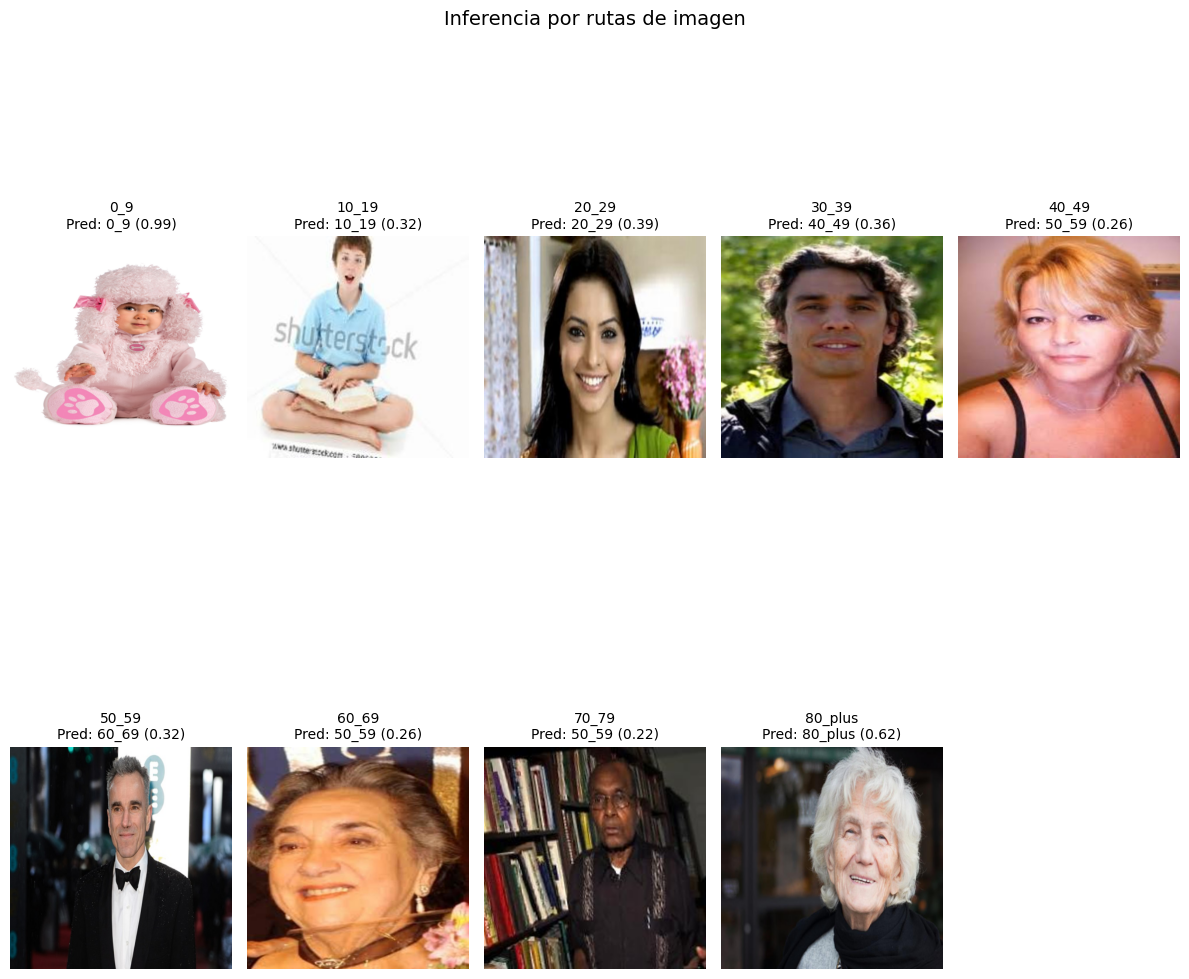

In [ ]:
# ===== Inferencia por rutas (archivos sueltos) =====
import os, glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image_for_model(path, img_size):
    img = Image.open(path).convert("RGB").resize(img_size)
    arr = np.array(img, dtype=np.float32)   # el modelo aplica preprocess internamente
    arr = np.expand_dims(arr, axis=0)       # [1,H,W,3]
    return img, arr

# Ejemplos: toma 1 imagen de cada clase (si existe)
sample_paths = []
for cls in class_names:
    pattern = os.path.join(test_dir, cls, "*")
    files = glob.glob(pattern)
    if files:
        sample_paths.append(files[0])
    if len(sample_paths) >= 9:   # limita a 9 para el demo
        break

plt.figure(figsize=(12, 12))
for i, p in enumerate(sample_paths[:9]):
    img, arr = load_image_for_model(p, IMG_SIZE)
    prob = model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(prob))
    pred_cls = class_names[pred_idx]
    conf = float(np.max(prob))

    ax = plt.subplot(2, 5, i+1)
    plt.imshow(img)
    ax.set_title(f"{os.path.basename(os.path.dirname(p))}\nPred: {pred_cls} ({conf:.2f})", fontsize=10)
    ax.axis("off")

plt.suptitle("Inferencia por rutas de imagen", fontsize=14)
plt.tight_layout()
plt.show()


INFERENCIA A UN GRUPO DE IMAGENES

In [ ]:
# --- Cargar modelo .keras que contiene Lambda(preprocess_input) en tf.keras ---
import os, json, tensorflow as tf
from tensorflow import keras

MODEL_PATH = "export_efficientnet_b4_b5/ckpts/best_head.keras"   # <-- ajusta
CLASS_NAMES_PATH = "export_efficientnet_b4_b5/class_names.json"  # <-- ajusta

# 1) Trae la función oficial de EfficientNet y REGÍSTRALA para deserializar Lambdas
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.utils import register_keras_serializable, get_custom_objects

@register_keras_serializable(package="preproc", name="preprocess_input")
def _registered_preprocess(x):
    return eff_preprocess(x)

# Por si la Lambda fue nombrada "preprocess"
get_custom_objects().update({
    "preprocess_input": _registered_preprocess,
    "preprocess": _registered_preprocess,
})

# 2) Carga el modelo (en tf.keras NO uses safe_mode)
model = keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "preprocess_input": _registered_preprocess,
        "preprocess": _registered_preprocess
    }
)
print("Modelo cargado ✅")

# 3) Tamaño esperado por el modelo
in_shape = model.inputs[0].shape
IMG_SIZE = (int(in_shape[1]), int(in_shape[2]))
print("IMG_SIZE inferida del modelo:", IMG_SIZE)

# 4) Clases (si existe el JSON)
if os.path.exists(CLASS_NAMES_PATH):
    with open(CLASS_NAMES_PATH) as f:
        class_names = json.load(f)
    print("Clases:", class_names)
else:
    class_names = None
    print("No se encontró class_names.json (se mostrarán índices).")

print("TF version:", tf.__version__, "| Keras backend:", keras.__version__)

Modelo cargado ✅
IMG_SIZE inferida del modelo: (380, 380)
Clases: ['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_plus']
TF version: 2.19.0 | Keras backend: 3.10.0


In [ ]:
# Carga de labels (rangos de edad) con fallback
import os, json
from tensorflow import keras

# Asegúrate de que la ruta exista (ajústala a tu carpeta real)
CLASS_NAMES_PATH = "export_efficientnet_b4_b5/class_names.json"

# Fallback por si no existe el JSON (ajusta el orden si el tuyo es distinto)
FALLBACK_LABELS = ["0_9","10_19","20_29","30_39","40_49","50_59","60_69","70_79","80_plus"]

# 1) intentar leer del JSON
if os.path.exists(CLASS_NAMES_PATH):
    with open(CLASS_NAMES_PATH) as f:
        class_names = json.load(f)
else:
    class_names = FALLBACK_LABELS

# 2) sanity: si no coincide con el # de salidas del modelo, usa fallback recortado
num_out = model.output_shape[-1]
if len(class_names) != num_out:
    print(f"[!] class_names tenía {len(class_names)} entradas; el modelo tiene {num_out}. Se usará fallback.")
    class_names = FALLBACK_LABELS[:num_out]

print("[i] class_names =", class_names)


[i] class_names = ['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_plus']


Encontradas 9 imágenes en:
  imagenes_de_prueba


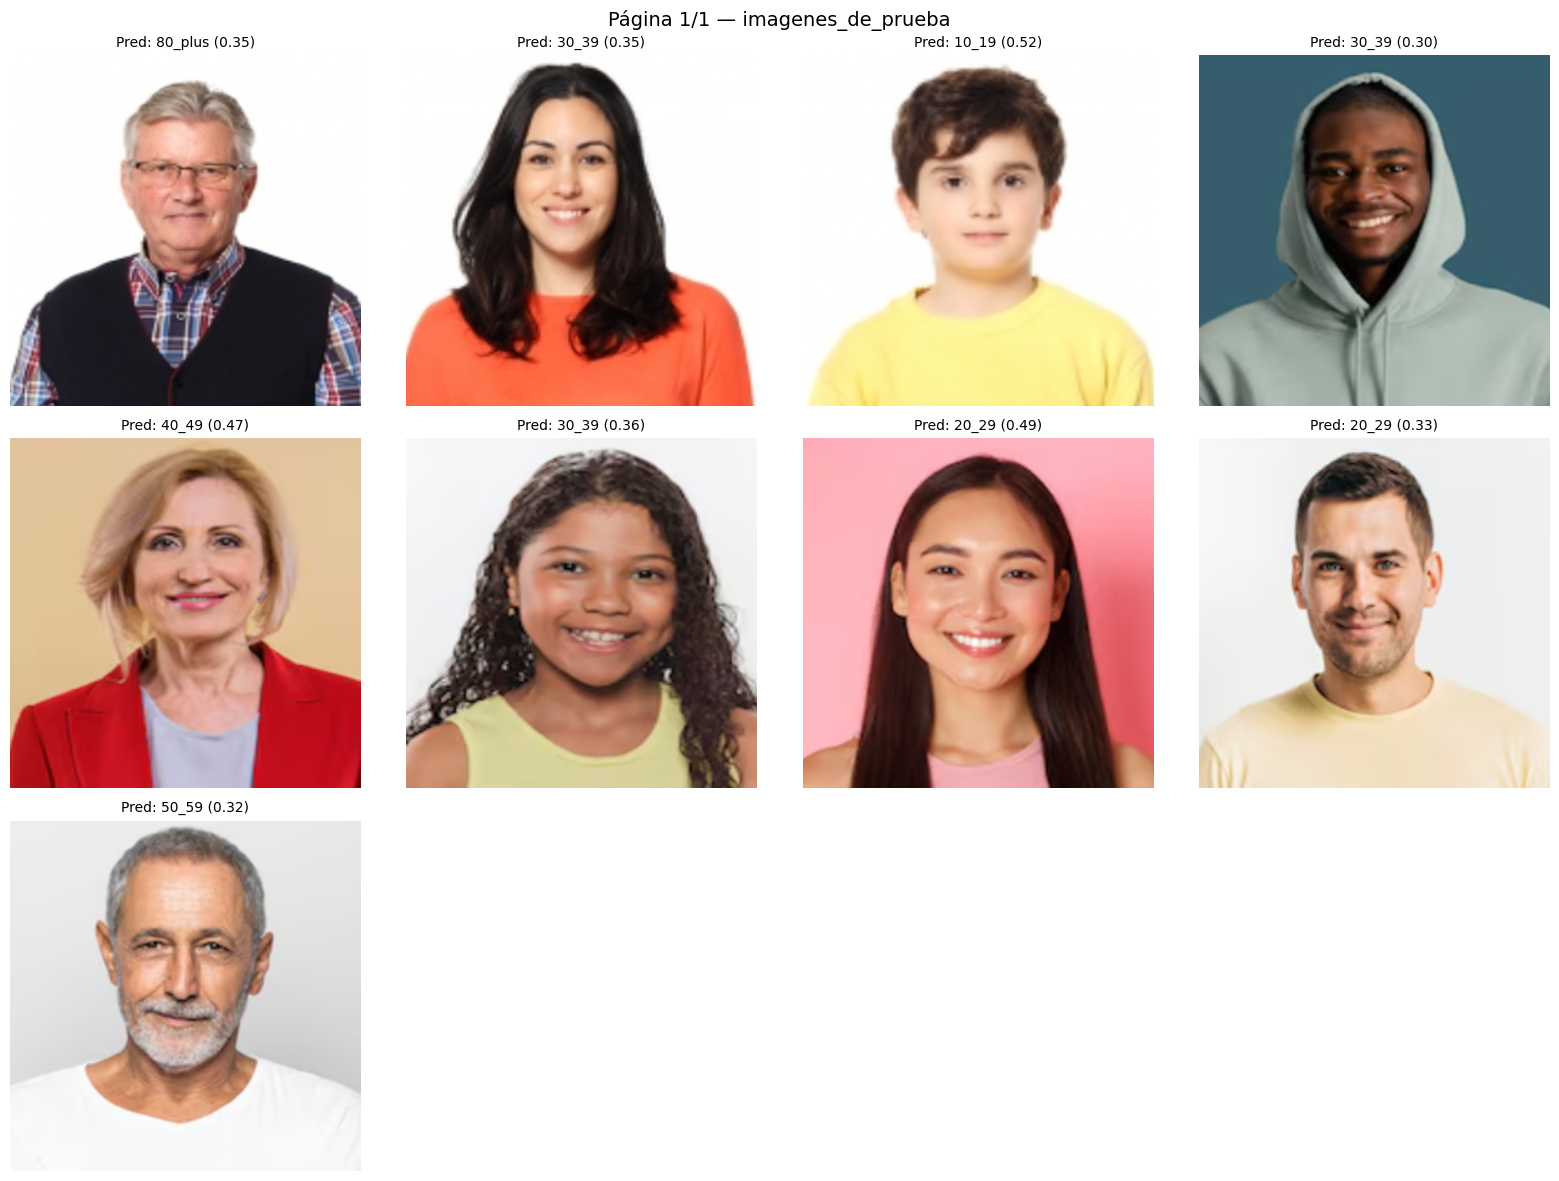

In [ ]:
# --- Inferencia en carpeta + visualización (Colab) ---
import os, glob, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# === CONFIG ===
FOLDER = "imagenes_de_prueba"  # <-- ajusta
RECURSIVE = True
BATCH_INFER = 16      # baja a 8/4 si hace falta
MAX_PER_PAGE = 16     # 4x4
MAX_PAGES = 10

def list_images(folder, recursive=True):
    exts = ["*.jpg","*.jpeg","*.png","*.bmp","*.webp"]
    files = []
    if recursive:
        for ext in exts:
            files += glob.glob(os.path.join(folder, "**", ext), recursive=True)
    else:
        for ext in exts:
            files += glob.glob(os.path.join(folder, ext))
    return sorted(files)

def load_img_arr(path, img_size):
    img = Image.open(path).convert("RGB").resize(img_size)
    arr = np.array(img, dtype=np.float32)   # el modelo aplica preprocess internamente
    return img, arr

def batched(iterable, n):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

img_paths = list_images(FOLDER, RECURSIVE)
print(f"Encontradas {len(img_paths)} imágenes en:\n  {FOLDER}")
if not img_paths:
    raise SystemExit("No se encontraron imágenes; revisa FOLDER.")

# --- Inferencia por lotes ---
all_preds, all_confs, all_true = [], [], []
for batch_paths in batched(img_paths, BATCH_INFER):
    batch_imgs = []
    for p in batch_paths:
        _, arr = load_img_arr(p, IMG_SIZE)
        batch_imgs.append(arr)
    batch_x = np.stack(batch_imgs, axis=0)                # [N,H,W,3] float32
    probs = model.predict(batch_x, verbose=0)             # modelo ya contiene preprocess
    preds = np.argmax(probs, axis=1)
    confs = np.max(probs, axis=1)

    all_preds.extend(preds.tolist())
    all_confs.extend(confs.tolist())

    # Etiqueta "real" si la carpeta padre coincide con una clase conocida
    for p in batch_paths:
        parent = os.path.basename(os.path.dirname(p))
        all_true.append(parent if (class_names and parent in class_names) else None)

# --- Visualización paginada ---
def show_pages(paths, preds, confs, ytrue, class_names, img_size, max_per_page=16, max_pages=10):
    pages = min(math.ceil(len(paths)/max_per_page), max_pages)
    for pg in range(pages):
        start = pg * max_per_page
        end   = min((pg+1) * max_per_page, len(paths))
        n     = end - start
        cols  = 4
        rows  = math.ceil(n/cols)
        plt.figure(figsize=(4*cols, 4*rows))
        for i, idx in enumerate(range(start, end), start=1):
            p = paths[idx]
            pred_idx = int(preds[idx])
            conf = confs[idx]
            pred_label = class_names[pred_idx]  # <-- usa el rango de edad
            true_cls = ytrue[idx]

            img = Image.open(p).convert("RGB").resize(img_size)
            ax = plt.subplot(rows, cols, i)
            ax.imshow(img)
            title = f"Pred: {pred_label} ({conf:.2f})"
            if true_cls is not None:
                title = f"GT: {true_cls}\n" + title
            ax.set_title(title, fontsize=10)
            ax.axis("off")
        plt.suptitle(f"Página {pg+1}/{pages} — {os.path.basename(FOLDER)}", fontsize=14)
        plt.tight_layout()
        plt.show()

show_pages(img_paths, all_preds, all_confs, all_true, class_names, IMG_SIZE,
           max_per_page=MAX_PER_PAGE, max_pages=MAX_PAGES)


DESCARGAR EL MODELO

In [ ]:
# Descarga tu modelo y metadatos desde Colab
import os, shutil
from google.colab import files

# Ajusta si guardaste en otra ruta
OUTDIR = "export_efficientnet_b4_b5/ckpts"   # carpeta donde guardaste model.keras, class_names.json, metrics.json
MODEL_PATH = os.path.join(OUTDIR, "best_head.keras")

# Opción A: descargar SOLO el .keras
if os.path.exists(MODEL_PATH):
    print("Descargando:", MODEL_PATH)
    files.download(MODEL_PATH)
else:
    print("No se encontró:", MODEL_PATH)


Descargando: export_efficientnet_b4_b5/ckpts/best_head.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Opción B: descargar TODO el directorio como ZIP (modelo + class_names.json + metrics.json + ckpts/)
!zip -r /content/export_efficientnet_b4_b5.zip /content/export_efficientnet_b4_b5